In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter

import numpy as np
from pyleoclim import Spectral

## Generate evenly-spaced timeseries and delete some points

In [2]:
def gen_noise(alpha, t, f0=None, m=None):
    ''' Generate a colored noise timeseries

    Args:
        alpha (float): exponent of the 1/f^alpha noise
        t (float): time vector of the generated noise
        f0 (float): fundamental frequency
        m (int): maximum number of the waves, which determines the
            highest frequency of the components in the synthetic noise

    Returns:
        y (array): the generated 1/f^alpha noise

    References:
        Eq. (15) in Kirchner, J. W. Aliasing in 1/f(alpha) noise spectra: origins, consequences, and remedies.
            Phys Rev E Stat Nonlin Soft Matter Phys 71, 066110 (2005).
    
    '''
    n = np.size(t)  # number of time points
    y = np.zeros(n)

    if f0 is None:
        f0 = 1/n  # fundamental frequency
    if m is None:
        m = n

    k = np.arange(m) + 1  # wave numbers

    theta = np.random.rand(int(m))*2*np.pi  # random phase
    for j in range(n):
        coeff = (k*f0)**(-alpha/2)
        sin_func = np.sin(2*np.pi*k*f0*t[j] + theta)
        y[j] = np.sum(coeff*sin_func)

    return y

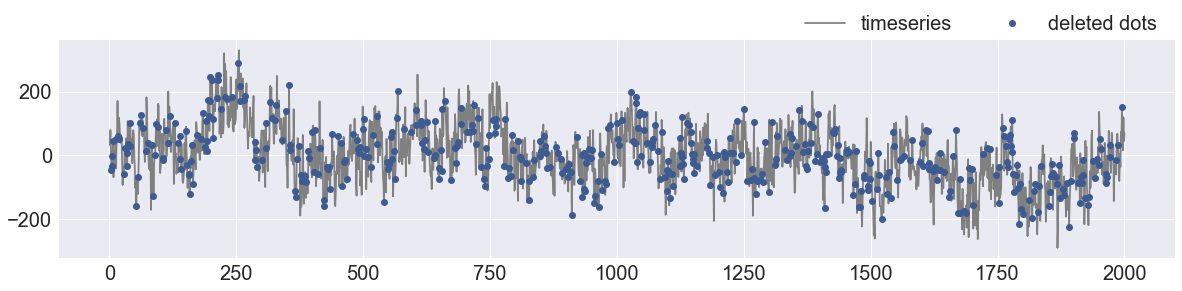

In [3]:
to_evenly = np.arange(1, 2001)
Xo_evenly = gen_noise(1, to_evenly)

import random
random.seed(2333)
n_del = 500  # delete 500 pts from 2000 pts
deleted_idx = random.sample(range(np.size(to_evenly)), n_del)

to_unevenly =  np.delete(to_evenly, deleted_idx)
Xo_unevenly =  np.delete(Xo_evenly, deleted_idx)

sns.set(style="darkgrid", font_scale=2)
plt.subplots(figsize=[20, 4])
plt.plot(to_evenly, Xo_evenly, color='gray', label='timeseries')
plt.plot(to_evenly[deleted_idx], Xo_evenly[deleted_idx], 'o', color=sns.xkcd_rgb['denim blue'], label='deleted dots')
plt.legend(fontsize=20, bbox_to_anchor=(1, 1.2), loc='upper right', ncol=3)

In [4]:
print(np.sort(deleted_idx))

[   3    4    5    6   11   16   17   28   29   33   34   36   39   40
   52   56   60   61   66   71   75   83   84   88   91   94  104  105
  110  114  118  128  135  138  139  140  149  152  155  156  157  160
  161  164  172  179  183  187  190  191  192  193  195  197  198  201
  203  204  211  212  213  218  226  231  241  252  256  257  264  267
  285  286  288  290  300  307  308  315  320  326  327  339  346  353
  354  355  364  367  368  373  376  379  383  384  387  391  393  399
  403  404  410  414  421  422  428  429  431  434  438  450  456  458
  462  464  468  479  487  488  491  492  499  500  501  504  508  514
  518  526  527  540  546  548  549  554  555  556  560  562  566  567
  579  594  603  604  612  613  615  619  621  624  627  638  640  641
  648  649  652  654  655  661  673  679  682  684  686  691  692  704
  709  713  715  718  722  725  731  738  739  741  743  746  747  755
  759  760  761  777  778  785  786  791  792  794  805  808  809  810
  820 

## Compare PSDs of evenly/unevenly-spaced timeseries

In [32]:
freqs = None
tau_evenly = np.linspace(np.min(to_evenly), np.max(to_evenly), 101)
tau_unevenly = np.linspace(np.min(to_unevenly), np.max(to_unevenly), 101)
dcon = 1e-3

res_psd_evenly = Spectral.wwz_psd(Xo_evenly, to_evenly, freqs=freqs, tau=tau_evenly, c=dcon, standardize=False, nMC=0, anti_alias=False)
res_psd_unevenly = Spectral.wwz_psd(Xo_unevenly, to_unevenly, freqs=freqs, tau=tau_unevenly, c=dcon, standardize=False, nMC=0, anti_alias=False)

In [33]:
import nitime.algorithms as tsa
freq_mtm, psd_mtm, nu = tsa.multi_taper_psd(Xo_evenly, adaptive=False, jackknife=False, NW=2, Fs=1)

/Users/fzhu/.pyenv/versions/anaconda3-5.0.1/envs/py3.6/lib/python3.6/site-packages/nitime/utils.py:980: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  complex_result = (np.issubdtype(in1.dtype, np.complex) or
/Users/fzhu/.pyenv/versions/anaconda3-5.0.1/envs/py3.6/lib/python3.6/site-packages/nitime/utils.py:981: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  np.issubdtype(in2.dtype, np.complex))


In [34]:
freq_range = [1/200, 1/10]

res_beta_evenly = Spectral.beta_estimation(
    res_psd_evenly.psd, res_psd_evenly.freqs, freq_range[0], freq_range[1]
)

res_beta_unevenly = Spectral.beta_estimation(
    res_psd_unevenly.psd, res_psd_unevenly.freqs, freq_range[0], freq_range[1]
)

res_beta_mtm = Spectral.beta_estimation(
    psd_mtm, freq_mtm, freq_range[0], freq_range[1]
)

/Users/fzhu/.pyenv/versions/anaconda3-5.0.1/envs/py3.6/lib/python3.6/site-packages/pyleoclim-0.4.7-py3.6.egg/pyleoclim/Spectral.py:2574: RuntimeWarning: divide by zero encountered in true_divide
  x_data = 1 / freqs
/Users/fzhu/.pyenv/versions/anaconda3-5.0.1/envs/py3.6/lib/python3.6/site-packages/pyleoclim-0.4.7-py3.6.egg/pyleoclim/Spectral.py:2576: RuntimeWarning: divide by zero encountered in true_divide
  x_data_ar1 = 1 / freqs
/Users/fzhu/.pyenv/versions/anaconda3-5.0.1/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/Users/fzhu/.pyenv/versions/anaconda3-5.0.1/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


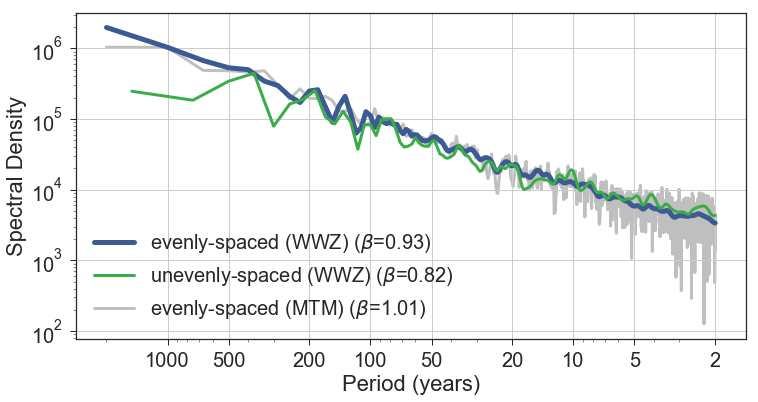

In [35]:
period_ticks = [2, 5, 10, 20, 50, 100, 200, 500, 1000]

fig = Spectral.plot_psd(res_psd_evenly.psd, res_psd_evenly.freqs, plot_ar1=False, psd_ar1_q95=None, period_ticks=period_ticks,
                        lmstyle='-', label=r'evenly-spaced (WWZ) ($\beta$={:.2f})'.format(res_beta_evenly.beta), figsize=[12, 6], linewidth=5)
plt.plot(1/res_psd_unevenly.freqs, res_psd_unevenly.psd, '-', linewidth=3, label=r'unevenly-spaced (WWZ) ($\beta$={:.2f})'.format(res_beta_unevenly.beta), color=sns.xkcd_rgb['medium green'])
plt.plot(1/freq_mtm, psd_mtm, '-', linewidth=3, label=r'evenly-spaced (MTM) ($\beta$={:.2f})'.format(res_beta_mtm.beta), color='gray', alpha=0.5, zorder=-1)

# plt.plot(1/res_beta_evenly.f_binned, res_beta_evenly.Y_reg, '--', color='k', linewidth=3, zorder=99)
# plt.plot(1/res_beta_unevenly.f_binned, res_beta_unevenly.Y_reg, '--', color='k', linewidth=3, zorder=99)
# plt.plot(1/res_beta_mtm.f_binned, res_beta_mtm.Y_reg, '--', color='k', linewidth=3, zorder=99)

plt.legend()

## Benchmark dcon

/Users/fzhu/.pyenv/versions/anaconda3-5.0.1/envs/py3.6/lib/python3.6/site-packages/pyleoclim-0.4.7-py3.6.egg/pyleoclim/Spectral.py:2574: RuntimeWarning: divide by zero encountered in true_divide
  x_data = 1 / freqs
/Users/fzhu/.pyenv/versions/anaconda3-5.0.1/envs/py3.6/lib/python3.6/site-packages/pyleoclim-0.4.7-py3.6.egg/pyleoclim/Spectral.py:2576: RuntimeWarning: divide by zero encountered in true_divide
  x_data_ar1 = 1 / freqs
/Users/fzhu/.pyenv/versions/anaconda3-5.0.1/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide


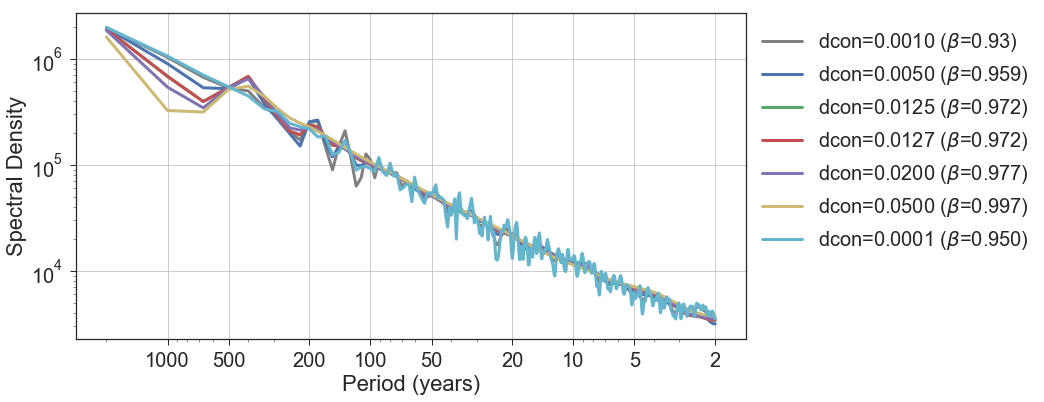

In [37]:
freqs = None
tau_evenly = np.linspace(np.min(to_evenly), np.max(to_evenly), 101)
res_psd = {}
res_beta = {}
freq_range = [1/200, 1/10]

# dcon options:
# + 1/(8*np.pi**2) from Witt & Schumann 2005
# + 0.0125 from Foster 1996
# + 0.001 from Kirchner & Neal 2013
for dcon in [0.001, 0.005, 0.0125, 1/(8*np.pi**2), 0.02, 0.05, 0.0001]:
    if dcon==0.001:
        fig = Spectral.plot_psd(res_psd_evenly.psd, res_psd_evenly.freqs, plot_ar1=False, psd_ar1_q95=None, period_ticks=period_ticks, color='gray',
                                lmstyle='-', label='dcon={:.4f}'.format(dcon)+r' ($\beta$={:.2f})'.format(res_beta_evenly.beta), figsize=[12, 6], linewidth=3)
    else:
        res_psd[str(dcon)] = Spectral.wwz_psd(Xo_evenly, to_evenly, freqs=freqs, tau=tau_evenly, c=dcon, standardize=False, nMC=0, anti_alias=False)
        res_beta[str(dcon)] = Spectral.beta_estimation(
                              res_psd[str(dcon)].psd, res_psd[str(dcon)].freqs, freq_range[0], freq_range[1]
                          )
        plt.plot(1/res_psd[str(dcon)].freqs, res_psd[str(dcon)].psd, '-', linewidth=3, label='dcon={:.4f} '.format(dcon)+r'($\beta$={:.3f})'.format(res_beta[str(dcon)].beta))
                 
plt.legend(fontsize=20, bbox_to_anchor=(1.45, 1), loc='upper right', ncol=1)

## Wavelet analysis

/Users/fzhu/.pyenv/versions/anaconda3-5.0.1/envs/py3.6/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/fzhu/.pyenv/versions/anaconda3-5.0.1/envs/py3.6/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/fzhu/.pyenv/versions/anaconda3-5.0.1/envs/py3.6/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
Monte-Carlo simulations: 100%|███████

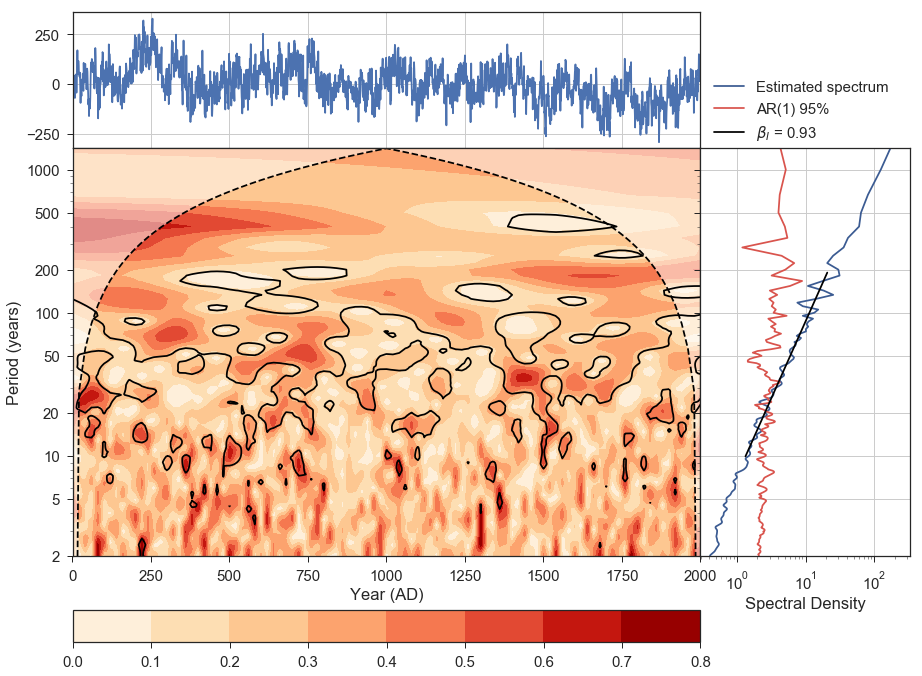

In [38]:
# evenly-spaced timeseries
freqs = None
tau_evenly = np.linspace(np.min(to_evenly), np.max(to_evenly), 101)
freq_range = [1/200, 1/10]
period_ticks = [2, 5, 10, 20, 50, 100, 200, 500, 1000]
fig = Spectral.plot_summary(Xo_evenly, to_evenly, nMC=5, ts_style='-', tau=tau_evenly, period_ticks=period_ticks, period_S=freq_range, period_L=None)

/Users/fzhu/.pyenv/versions/anaconda3-5.0.1/envs/py3.6/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/fzhu/.pyenv/versions/anaconda3-5.0.1/envs/py3.6/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/fzhu/.pyenv/versions/anaconda3-5.0.1/envs/py3.6/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
Monte-Carlo simulations: 100%|███████

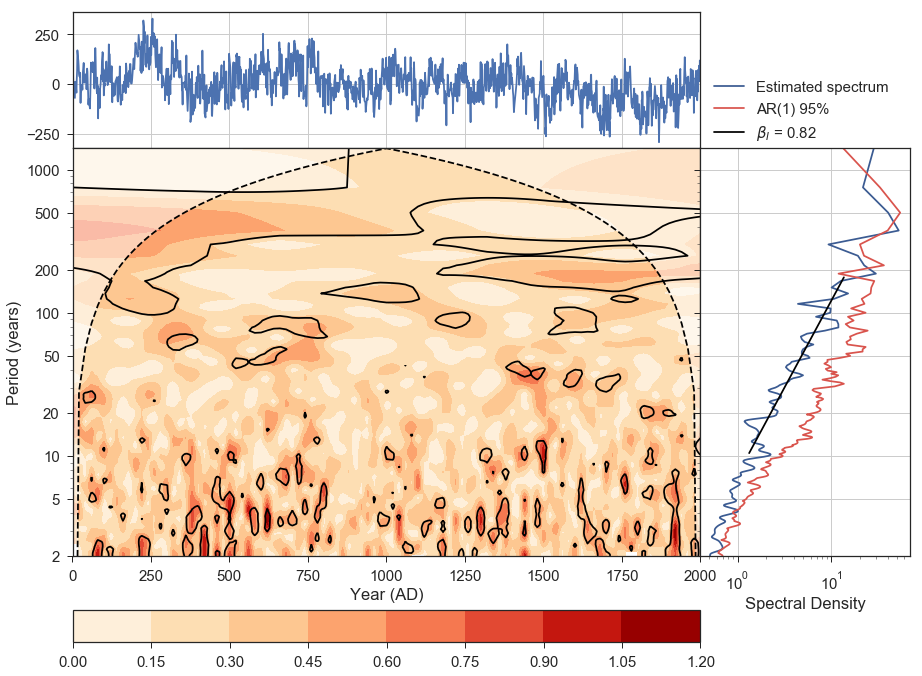

In [39]:
# unevenly-spaced timeseries
freqs = None
tau_unevenly = np.linspace(np.min(to_unevenly), np.max(to_unevenly), 101)
freq_range = [1/200, 1/10]
period_ticks = [2, 5, 10, 20, 50, 100, 200, 500, 1000]
fig = Spectral.plot_summary(Xo_unevenly, to_unevenly, nMC=5, ts_style='-', tau=tau_unevenly, period_ticks=period_ticks, period_S=freq_range, period_L=None)